<a href="https://colab.research.google.com/github/pds2021/capstone-group_2/blob/Projekt_PDS/4_resnetClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Klassifizierung der iWildCam-2020-fgvc7-Bilder 
Aufgrund der Problematiken mit der Datenmenge hat sich das Team dazu entschieden, auf die Kaggle Notebooks zu wechseln. Aufgrund der Laufzeit-Beschränkungen der Kaggle Notebooks von maximal neun Stunden und eine Maximallaufzeit der GPU von 43 Stunden pro Woche mussten die Umsetzungen eingeschränkt werden. Um jedoch die Kaggle-Abgabe durchführen zu können und einen Score zu erhalten, wurde parallel ein zweiter, schnellerer Standard-Weg erarbeitet. Dieses Notebook enthält ein vereinfachtes Verfahren zur Klassifizierung von Bilddaten und wurde für das Projekt angewendet.

# Imports
Zuerst werden alle benötigten Bibliotheken für die Erfüllung der Aufgabe importiert und gegebenenfalls installiert.

In [ ]:
#Installierung von FastAI
!pip install -Uqq fastai

In [ ]:
#Imports
import os
import json
import csv
import numpy as np
import pandas as pd
from fastai import *
from fastai.vision.all import *

# Öffnen und Vorbereiten der Daten
In diesem Schritt werden die Daten für die Verarbeitung aufbereitet und ausgewählt.
Hierfür wird die Datei "iwildcam2020_train_annotations.json" geöffnet und analysiert.
Diese enthält die Bereiche "annotations", "images", "categories" und  "info".

In [ ]:
#Öffnen der Datei und Zugreifen auf die Daten
with open(r'/kaggle/input/iwildcam-2020-fgvc7/iwildcam2020_train_annotations.json') as json_file:
    train_data = json.load(json_file)

In [ ]:
#Temporäre Zwischenspeicherung der Daten aus der Datei
train_annotations = train_data['annotations']
train_images = train_data['images']
train_categories = train_data['categories']
train_info = train_data['info']

In [ ]:
#Überführung der Daten in pandas DataFrames
train_categories = pd.DataFrame.from_dict(train_categories)
train_annotations = pd.DataFrame.from_dict(train_annotations)
train_categories = train_categories.rename(columns={"count": "Counter", "id": "CategoryID", "name": "Name"})

In [ ]:
#Erzeugen einer Liste aller verfügbarer Kategorien
categoryList = train_categories["CategoryID"].values.tolist()

# Auswahl der Daten
Die Trainingsdaten enthalten 267 Kategorien mit unterscheidlicher Menge an Bildern. Es existiert eine hohe Differenz zwischen der Repräsentation der Bilder pro Kategorie. Eine Kategorie besitzt zum Beispiel 74.217 Bilder, wohingegen eine andere nur 3 Bilder enthält.
Die Trainingsdaten enthalten 217.959 Bilder. Da aufgrund der begrenzten Notebook-Laufzeit nicht alle Bilder genutzt werden können, musste eine sinnvolle Reduzierung der Bilder vorgenommen werden. Außerdem ist eine so unterschiedliche Verteilung der Bilder für den Trainingsprozess nicht unbedingt sinnvoll. Zuletzt sind bestimmte Kategorien so unterrepräsentiert und können somit im Trainingsprozess nicht erfolgreich antrainiert werden. Somit wurde weiterhin entschieden, unterrepräsentierte Kategorien aus dem Prozess zu nehmen.

Es wurden verschiedene Mengen an Bildern und Kategorien ausprobiert.
* maximal 200 Bilder pro Kategorie und Kategorien mit mindestens 20 Bildern = Genauigkeit 0,23
    * Bilder 16.957; Kategorien 127
* maximal 500 Bilder pro Kategorie und Kategorien mit mindestens 50 Bildern = Genauigkeit 0,27
    * Bilder 31.379; Kategorien 95 
* maximal 800 Bilder pro Kategorie und Kategorien mit mindestens 50 Bildern = Genauigkeit 0,28
    * Bilder 43.089; Kategorien 95
* maximal 800 Bilder pro Kategorie und Kategorien mit mindestens 80 Bildern = Genauigkeit 0,37
    * Bilder 42.351; Kategorien 84
* maximal 1000 Bilder pro Kategorie und Kategorien mit mindestens 100 Bildern = Genauigkeit 0,44
    * Bilder 48.994; Kategorien 78
    
Je mehr Bilder enthalten sind, desto besser wurde die Genauigkeit, jedoch je mehr Kategorien, desto schlechter sind unterrepräsentierte Kategorien vertreten.
Weiterhin dauerten die Durchläufe des Trainings bei vielen Bildern teilweise bis zu einer Stunde, weswegen hier auch die Anzahl limitiert werden musste, um mit der Notebook-Laufzeitbegrenzung keine Probleme zu erhalten.

Die Kaggle-Abgabe wurde auf Basis der letzten Variante durchgeführt und somit pro Kategorie maximal 1000 Bilder herangezogen. Und nur Kategorien mit mindestens 100 Bildern für das Training genutzt.

In [ ]:
#Filtern der Bilder
#Erstellen einer Liste, die die ausgewählten Bilder enthält.
imageList = []
for category in categoryList:
    dfTemp = train_annotations.copy()
    quantityImages = dfTemp[(dfTemp.category_id == category)].shape[0]
    if quantityImages > 1000:
        imageList = imageList + dfTemp[(dfTemp.category_id == category)][:1000].values.tolist()
    elif quantityImages >= 100:
        imageList = imageList + dfTemp[(dfTemp.category_id == category)].values.tolist()

In [ ]:
#Hinzufügen der Zugriffspfade der Bilder.
for image in imageList:
    image[1] = '../input/iwildcam-2020-fgvc7/train/' + image[1] + '.jpg'

In [ ]:
#Rückführung in ein DataFrame und setzen der Spaltennamen
columns = [ 'counter', 'image_path', 'id', 'category_id']
dfNew = pd.DataFrame(imageList, columns=columns)

# Erzeugung des DataLoaders

Für die Erstellung des DataLoaders wurden unterschiedliche Varianten getestet.
Zum einen wurde die Funktion des Resize angewandt um zu gewährleisten, dass alle Bilder die gleiche Größe haben. Andererseits wurden hierdurch große Bilder auf eine kleinere und kompaktere Version umgewandelt.
Weiterhin wurde die Augmentation eingesetzt, um zum Beispiel bei Kategorien, welche zu wenig Bilder aufweisen, mehrere synthetische Varianten zu erzeugen. 
Hier wurde sowohl mit als, auch ohne die Augmentation getestet, die Genauigkeit konnte dadurch auf 0,44 gesteigert werden. Ohne den Einsatz konnte nur eine Genauigkeit von 0,28 erreicht werden.

In [ ]:
#Erstellung des DataBlocks
wildcam = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_x=ColReader('image_path'),
                 get_y=ColReader('category_id'),
                 splitter=RandomSplitter(valid_pct=0.15, seed=42),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75)
                 )

In [ ]:
#Erstellung des DataLoaders
dls = wildcam.dataloaders(dfNew)

In [ ]:
#Anzeige der Bilder mit deren Kategorien
dls.show_batch(figsize=(15,15))

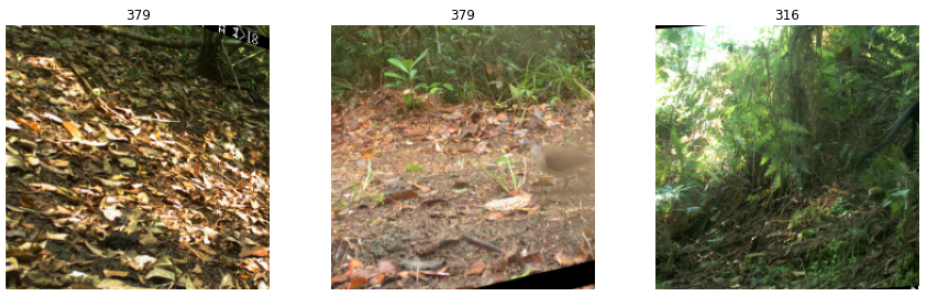

# Training des Models

In [ ]:
#Erstellung des Learners
learn = cnn_learner(dls, models.resnet34, metrics=accuracy)

In [ ]:
#Finden der Lernrate
learn.lr_find()
#Hier ist als Ergebnis folgendes herausgekommen:
#SuggestedLRs(lr_min=0.005754399299621582, lr_steep=6.309573450380412e-07)

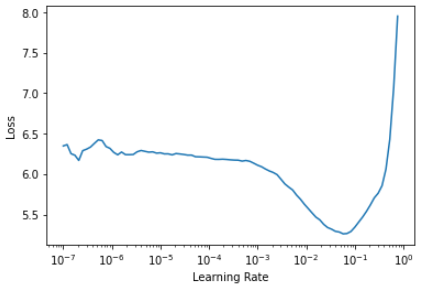

In [ ]:
#Training des Models
learn.fit_one_cycle(6, lr_max=0.0057)

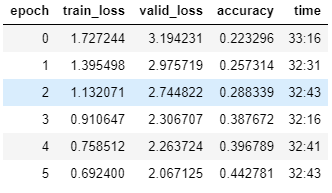

In [ ]:
#Zwischenspeichern des trainierten Models
learn.save('stage-1')

In [ ]:
#Unfreeze
learn.unfreeze()

In [ ]:
#Lernrate finden
learn.lr_find()

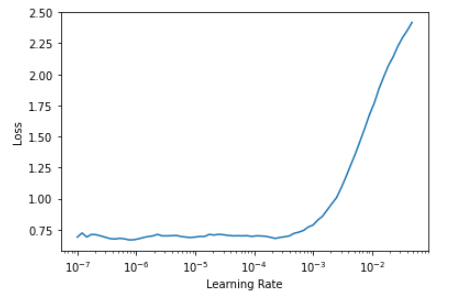

In [ ]:
#Zweiter Traingslauf
learn.fit_one_cycle(6, slice(0.00000007, 0.000002))

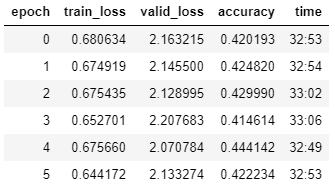

In [ ]:
#Interpretation: Top Losses
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(25,25))

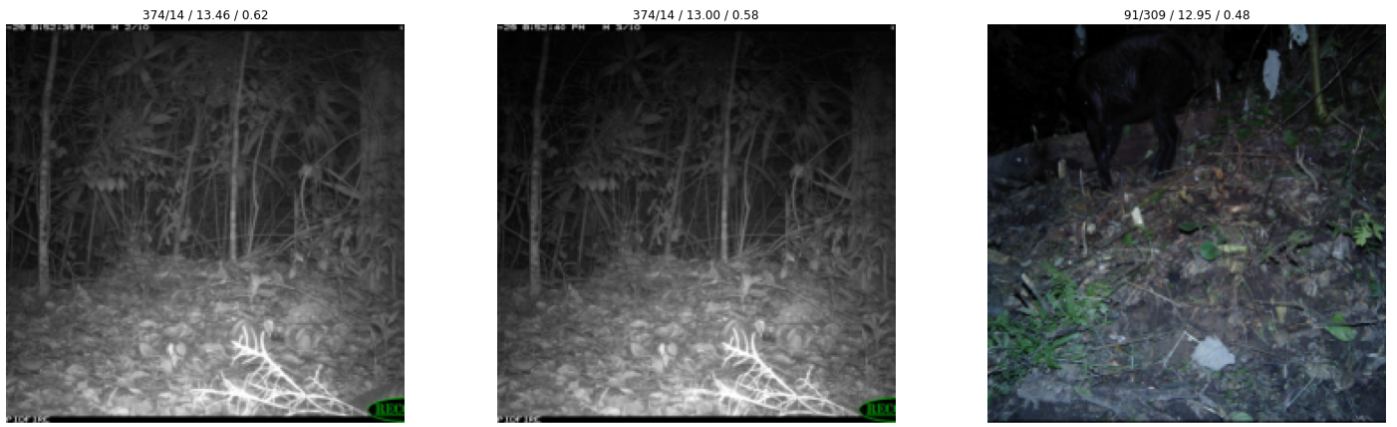

Mit Top Losses ist zu erkennen, dass die Bilder anhand des Hintergrundes falsch erkannt werden können.

In [ ]:
#Interpretation: Confusion Matrix
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

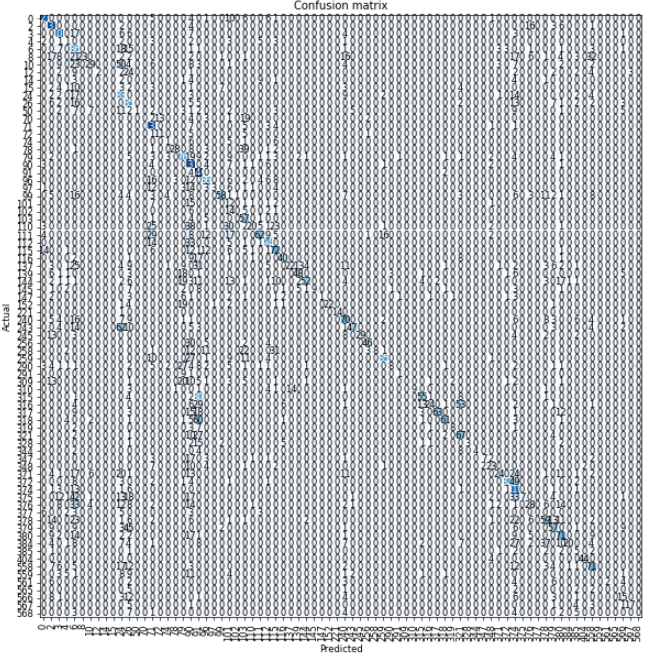

Expected: Jede Zeile der Matrix entspricht einer vorhergesagten Klasse.
Predicted: Jede Spalte der Matrix entspricht einer tatsächlichen Klasse.
Die Anzahl der richtigen und falschen Klassifizierungen wird dann in die Tabelle eingetragen.
Die Gesamtzahl der richtigen Vorhersagen für eine Klasse geht in die erwartete Zeile für diesen Klassenwert und die vorhergesagte Spalte für diesen Klassenwert.
Ebenso wird die Gesamtzahl der falschen Vorhersagen für eine Klasse in die erwartete Zeile für diesen Klassenwert und die vorhergesagte Spalte für diesen Klassenwert eingetragen.

Aus der Confusion-Matrix ist zu erkennen, dass es relativ wenige False Positives gibt. Weiterhin ist zu sehen, dass die Anzhal der False Negatives auch gering ist.

In [ ]:
#Export des Models
learn.export()

# Prediction der Testbilder für Kaggle-Abgabe
Vorhersage der Bilder aus dem Test-Ordner.
Hier ist aufgefallen, dass 24 Bilder nicht geöffnet/verarbeitet werden können.
Da jedoch in dem Testorder 62.894 Bilder enthalten sind und für die Kaggle-Abgabe eine CSV mit 62.870 Bilder erwartet ist, stellt dies kein Problem dar. Um den Fehler zu entgehen, wurde die Prediction in einem Try-Block verbaut um hier die Fehler abzufangen.

In [ ]:
#Speicherung der Prediction Daten in einer Liste
results = [""]
list = Path('../input/iwildcam-2020-fgvc7/test').ls()
for element in list:
    try:
        id = str(element)[34:]
        pred,pred_idx,probs = learn.predict(str(element))
        results.append([id[:-4], pred])
    except Exception:
        continue
#Entfernen der ersten Zeile, da diese einen leeren Eintrag enthält
results = results[1:]

In [ ]:
#Erzeugen der Abgabe-CSV mit Überschriften
file = open('submission.csv', 'w')
file.write("Id,Category\n")
#Schreiben der Prediction Ergebnisse in die CSV
for line in results:
    file.write(line[0] + "," + line[1] + "\n")
#Schließen der Datei nachdem diese erfolgreich beschrieben wurde
file.close()

# Kaggle-Score
Es wurden zwei Abgaben bei Kaggle durchgeführt.
1. Die erste Abgabe erreicht einen Kaggle-Score von 0.074 (Private Score) und 0.113 (Public Score)
2. Die zweite Abgabe erreicht einen Kaggle-Score von 0.097 (Private Score) und 0.148 (Public Score)

Für beide Abgaben wurden für das Training das Verfahren mit maximal 1000 Bildern pro Kategorie, sowie minimal 100 Bilder pro Kategorie genutzt.

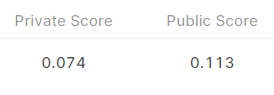

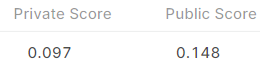

# Quellen

* https://www.kaggle.com/c/iwildcam-2020-fgvc7/discussion/135200
* https://colab.research.google.com/github/pds2021/course/blob/main/nbs/07_Data_to_Production.ipynb
* https://colab.research.google.com/github/pds2021/course/blob/main/nbs/06_Image%20Classification.ipynb
* https://www.kaggle.com/c/iwildcam-2020-fgvc7/overview
* https://www.kaggle.com/c/iwildcam-2020-fgvc7/data
* https://github.com/visipedia/iwildcam_comp
* https://machinelearningmastery.com/confusion-matrix-machine-learning/